In [0]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#from covidimage import CovidImage
#from classifier_maria import Classifier

In [2]:
# Set up data path
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Hyperparameters
EPOCHS = 25
INIT_LR = 0.001
BS = 32

In [0]:
class Classifier:
    @staticmethod
    def build(width, height, depth, classes):
        
        model = Sequential()
        inputShape = (height, width, depth)
        
        model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu', input_shape=inputShape))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
        model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
        
        model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
        model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
        
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.2))
        
        model.add(Dense(classes, activation='softmax'))
        
        print("summary")
        print(model.summary())
        
        return model

In [0]:
with open('/content/drive/My Drive/data/trainX1.pickle', 'rb') as f:
  X1 = pickle.load(f)
with open('/content/drive/My Drive/data/trainX2.pickle', 'rb') as f:
  X2 = pickle.load(f)
trainX = np.concatenate((X1, X2))

with open('/content/drive/My Drive/data/testX.pickle', 'rb') as f:
  testX = pickle.load(f)

with open('/content/drive/My Drive/data/train_y.pickle', 'rb') as f:
  train_y = pickle.load(f)
with open('/content/drive/My Drive/data/test_y.pickle', 'rb') as f:
  test_y = pickle.load(f)

In [0]:
# Reshape datasets for Sequential model
trainX = np.expand_dims(trainX, axis=-1) 
testX = np.expand_dims(testX, axis=-1) 

# One-hot encoding of classes
train_y = to_categorical(train_y, num_classes=3)

In [0]:
# TODO: shuffle (sample from all classes evenly)

# Split training data for training and validation
trainX, valX, train_y, val_y = train_test_split(trainX, train_y, test_size=0.30, random_state=42)

In [8]:
# Build model and its chracteristics
model = Classifier.build(width=224, height=224, depth=1, classes=3)

opt = Adam(lr=INIT_LR, decay=INIT_LR/EPOCHS)

model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])

# Callbacks: early stopping and checkpoint
early_stopping = EarlyStopping(monitor='val_accuracy', verbose=1, 
                               patience=10,
                               mode='max',
                               restore_best_weights=True)

filepath = "weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

callbacks_list = [early_stopping, checkpoint]

# Construct image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, 
                         zoom_range=0.01, horizontal_flip=True,
                         vertical_flip=False, fill_mode="nearest")


summary
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40000)      

In [9]:
print("Training network...")
history = model.fit(aug.flow(trainX, train_y, batch_size=BS),
                    validation_data=(valX, val_y),
#                    validation_split=0.3,
                    steps_per_epoch=len(trainX) // BS,
#                   validation_steps=int(len(trainX) / 3)// BS,
                    callbacks=[early_stopping],
                    epochs=EPOCHS, verbose=1)

Training network...
Epoch 1/25
298/298 [==============================] - 36s 120ms/step - loss: 0.3738 - accuracy: 0.7379 - val_loss: 0.3305 - val_accuracy: 0.8035
Epoch 2/25
298/298 [==============================] - 35s 118ms/step - loss: 0.3212 - accuracy: 0.7996 - val_loss: 0.3098 - val_accuracy: 0.8118
Epoch 3/25
298/298 [==============================] - 35s 118ms/step - loss: 0.3057 - accuracy: 0.8135 - val_loss: 0.2804 - val_accuracy: 0.8380
Epoch 4/25
298/298 [==============================] - 35s 117ms/step - loss: 0.2914 - accuracy: 0.8228 - val_loss: 0.2585 - val_accuracy: 0.8480
Epoch 5/25
298/298 [==============================] - 34s 116ms/step - loss: 0.2751 - accuracy: 0.8370 - val_loss: 0.2542 - val_accuracy: 0.8539
Epoch 6/25
298/298 [==============================] - 35s 116ms/step - loss: 0.2744 - accuracy: 0.8363 - val_loss: 0.2538 - val_accuracy: 0.8512
Epoch 7/25
298/298 [==============================] - 35s 118ms/step - loss: 0.2719 - accuracy: 0.8386 - val_l

In [12]:
# Test accuracy
test_y_pred = model.predict(testX)
test_y_pred_1 = np.argmax(test_y_pred, axis=1)
accuracy_score(test_y, test_y_pred_1)

0.8880794701986755

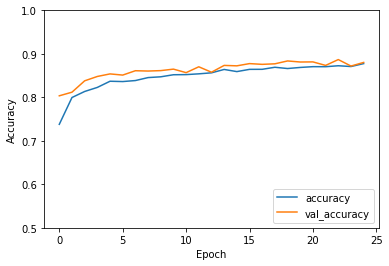

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [13]:
conf_matrix = confusion_matrix(test_y, test_y_pred_1, labels=[0, 1, 2])
print("Confusion matrix:")
print(conf_matrix)

Confusion matrix:
[[810  75   0]
 [ 65 529   0]
 [ 15  14   2]]
